## Data

In [34]:
import torch
import torchvision
from torchvision import transforms, datasets

train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test, batch_size=10, shuffle=False)

## Model

In [35]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=-1)

        return x

In [28]:
model = FCN()

FCN(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

## Training

In [29]:
optimizer = optim.Adam(model.parameters(), lr=1e-2)
epochs = 3


def calc_acc(model, dataset):
    total = 0
    correct = 0

    for xb,yb in dataset:
        yb_hat = model(xb)
        yb_hat = torch.argmax(yb_hat, dim=-1)

        correct += (yb == yb_hat).sum().item()
        total += yb_hat.size()[0]
                
    return round(correct/total*100, 3), correct, total

print('starting accuracy', calc_acc(model, testset))


for epoch in range(epochs):
    for xb,yb in testset:
        model.zero_grad()
        output = model(xb)
        loss = F.nll_loss(output, yb)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch} --")
    print(loss.item())
    print(calc_acc(model, testset))

Epoch 0 --
tensor(0.1316, grad_fn=<NllLossBackward>)
(90.05, 9005, 10000)
Epoch 1 --
tensor(0.0536, grad_fn=<NllLossBackward>)
(93.86, 9386, 10000)
Epoch 2 --
tensor(0.0358, grad_fn=<NllLossBackward>)
(94.92, 9492, 10000)


## Inference

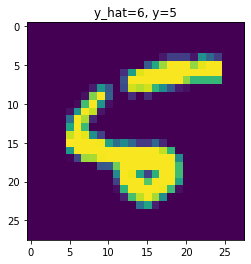

In [7]:
IDX = 8

with torch.no_grad():
    for xb,yb in testset:
        x = xb[IDX]
        y = yb[IDX]
        y_hat = model(x)
        y_hat = torch.argmax(y_hat)

        plt.imshow(xb[IDX].view(28, 28))
        plt.title(f"y_hat={y_hat}, y={y}")
        break
    
    

## Training with ignite

In [30]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers.tensorboard_logger import *

In [32]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

epochs = 3
optimizer = optim.Adam(model.parameters(), lr=1e-3f)
criterion = nn.NLLLoss()

metrics = {"accuracy": Accuracy(), "loss": Loss(criterion)}

trainer = create_supervised_trainer(model, optimizer, criterion)
train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
validation_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

@trainer.on(Events.EPOCH_COMPLETED)
def compute_metrics(engine):
    train_evaluator.run(trainset)
    validation_evaluator.run(testset)

tb_logger = TensorboardLogger(log_dir='/home/asdf/tensorboard')

tb_logger.attach(
    trainer,
    log_handler=OutputHandler(
        tag="training", output_transform=lambda loss: {"batchloss": loss}, metric_names="all"
    ),
    event_name=Events.ITERATION_COMPLETED(every=100),
)

tb_logger.attach(
    train_evaluator,
    log_handler=OutputHandler(tag="training", metric_names=["loss", "accuracy"], another_engine=trainer),
    event_name=Events.EPOCH_COMPLETED,
)

tb_logger.attach(
    validation_evaluator,
    log_handler=OutputHandler(tag="validation", metric_names=["loss", "accuracy"], another_engine=trainer),
    event_name=Events.EPOCH_COMPLETED,
)

tb_logger.attach(
    trainer, log_handler=OptimizerParamsHandler(optimizer), event_name=Events.ITERATION_COMPLETED(every=100)
)

tb_logger.attach(trainer, log_handler=WeightsScalarHandler(model), event_name=Events.ITERATION_COMPLETED(every=100))

tb_logger.attach(trainer, log_handler=WeightsHistHandler(model), event_name=Events.EPOCH_COMPLETED(every=100))

tb_logger.attach(trainer, log_handler=GradsScalarHandler(model), event_name=Events.ITERATION_COMPLETED(every=100))

tb_logger.attach(trainer, log_handler=GradsHistHandler(model), event_name=Events.EPOCH_COMPLETED(every=100))

trainer.run(trainset, max_epochs=epochs)
tb_logger.close()